In [1]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms
     

In [2]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
        pred = output >= 0.5 
        correct += pred.eq(target.view_as(pred)).sum().item()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item(), 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     name, test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)
     

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(1, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 1)
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        x = self.fc(x)
        return x

In [4]:
%%time
from torchvision.transforms.autoaugment import RandAugment
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.RandAugment(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []
loss_val = []
seed = randint(0,50)
prng = RandomState(seed)
random_permute = prng.permutation(np.arange(0, 1000))
train_top = 10//n_classes
val_top = 1000//n_classes
indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

train_data = Subset(train_dataset, indx_train)
val_data = Subset(val_dataset, indx_val)

print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=128, 
                                            shuffle=False)

model = Net()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

for epoch in range(50):
    l, a = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    loss_val.append(l)
    accs_val.append(a)

print('Val set: %.2f'%(test(model, device, val_loader)), '%')
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.693318
Train Epoch: 5 [0/10 (0%)]	Loss: 0.690908
Train Epoch: 10 [0/10 (0%)]	Loss: 0.686613
Train Epoch: 15 [0/10 (0%)]	Loss: 0.674950
Train Epoch: 20 [0/10 (0%)]	Loss: 0.613990
Train Epoch: 25 [0/10 (0%)]	Loss: 0.624913
Train Epoch: 30 [0/10 (0%)]	Loss: 0.649625
Train Epoch: 35 [0/10 (0%)]	Loss: 0.593192
Train Epoch: 40 [0/10 (0%)]	Loss: 0.395812
Train Epoch: 45 [0/10 (0%)]	Loss: 0.646488


c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: 83.70 %
CPU times: total: 1.52 s
Wall time: 1.28 s


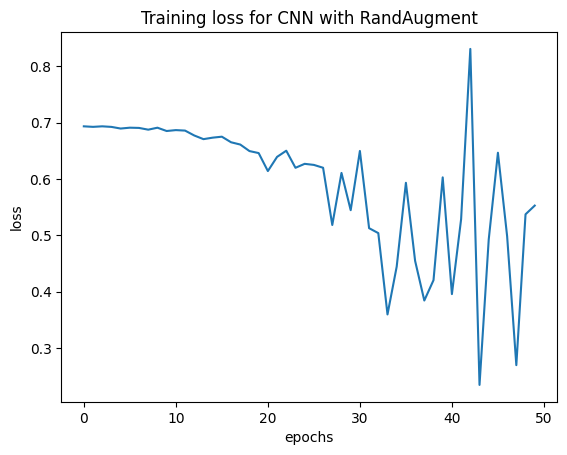

In [5]:
import matplotlib.pyplot as plt

plt.plot(loss_val)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss for CNN with RandAugment');
plt.savefig('hypertuned_loss_CNN_50.png')

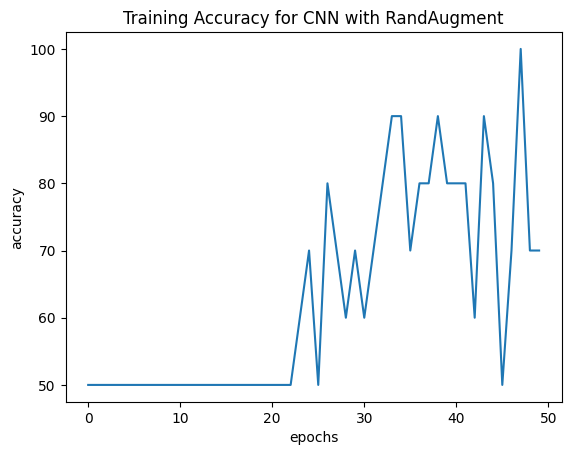

In [6]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy for CNN with RandAugment');
plt.savefig('hypertuned_acc_CNN_50.png')